# Regression Task: Global Climate & Energy Analysis
---
## 1. Exploratory Data Analysis and Data Understanding
### Choosing a Dataset
This project uses a dataset focusing on **Global Climate and Energy** metrics (2020-2024).

**Description:**
- **(a) Created by:** Environmental Data Research Initiative.
- **(b) Access:** Accessed via kaggle.
- **(c) UNSDG Alignment:** **Goal 7** (Affordable and Clean Energy) and **Goal 13** (Climate Action).
- **(d) Attributes:** `avg_temperature`, `humidity`, `co2_emission`, `renewable_share`, `urban_population`, `industrial_activity_index`, `energy_price`, and the target `energy_consumption`.

**Questions:**
1. Can we predict seasonal energy consumption based on climate variables?
2. Which factors (industrial activity vs. temperature) have the strongest impact on energy demand?

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df = pd.read_csv('/content/drive/MyDrive/ConceptAndTechnologiesOfAI/FinalAssignment/global_climate_energy_2020_2024.csv')
print(df.head())

         date  country  avg_temperature  humidity  co2_emission  \
0  2020-01-01  Germany            28.29     31.08        212.63   
1  2020-01-02  Germany            28.38     37.94        606.05   
2  2020-01-03  Germany            28.74     57.67        268.72   
3  2020-01-04  Germany            26.66     51.34        167.32   
4  2020-01-05  Germany            26.81     65.38        393.89   

   energy_consumption  renewable_share  urban_population  \
0            11348.75            14.42             76.39   
1             4166.64             5.63             86.26   
2             4503.80            14.20             75.92   
3             3259.13            13.84             63.15   
4             7023.72             6.93             76.02   

   industrial_activity_index  energy_price  
0                      51.22         83.93  
1                      78.27        110.40  
2                      48.96        173.58  
3                      97.42         89.13  
4          

### Data Preprocessing & 3-Month Aggregation
To reduce noise and align with seasonal trends, we aggregate the data into **3-month (quarterly)** intervals per country.

In [21]:
# Convert date and group by Country + 3-Month periods
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Grouping by country and resampling to 3-Month averages
df_3m = (
    df.groupby('country')
      .resample('3M', on='date')
      .mean(numeric_only=True)
      .reset_index()
)

df_3m = df_3m.fillna(df_3m.mean(numeric_only=True))

print(f"Dataset grouped into {df_3m.shape[0]} quarterly records.")
df_3m.head()

Dataset grouped into 420 quarterly records.


/tmp/ipython-input-1594172609.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('3M', on='date')


,country,date,avg_temperature,humidity,co2_emission,energy_consumption,renewable_share,urban_population,industrial_activity_index,energy_price
0,Australia,2020-01-31,29.129032,59.520323,448.193226,5738.055484,11.165161,73.819032,68.508710,119.663548
1,Australia,2020-04-30,34.125556,57.612667,527.932556,7894.507556,9.401889,74.526111,71.499556,121.449556
2,Australia,2020-07-31,23.519457,60.837826,370.277935,6118.968804,10.565217,74.660217,70.650109,115.577065
3,Australia,2020-10-31,13.015326,56.183370,532.911304,8549.576848,10.057935,75.719565,67.387065,120.835000
4,Australia,2021-01-31,23.550652,59.619022,385.865870,5741.446522,10.764674,76.330000,69.454239,116.773261


In [22]:
df.describe()

,date,avg_temperature,humidity,co2_emission,energy_consumption,renewable_share,urban_population,industrial_activity_index,energy_price
count,36540,36540.000000,36540.000000,36540.000000,36540.000000,36540.000000,36540.000000,36540.000000,36540.000000
mean,2022-07-02 00:00:00,13.580868,59.971469,445.820452,7295.904857,15.944080,74.982156,70.173094,115.279848
min,2020-01-01 00:00:00,-9.600000,30.000000,50.150000,1001.890000,5.000000,60.000000,40.000000,30.000000
25%,2021-04-01 00:00:00,5.630000,45.010000,248.675000,4184.177500,12.020000,67.470000,55.300000,72.420000
50%,2022-07-02 00:00:00,13.790000,59.990000,422.655000,6921.620000,15.715000,75.030000,70.055000,115.240000
75%,2023-10-02 00:00:00,20.840000,74.970000,628.422500,10175.110000,19.840000,82.502500,85.260000,158.270000
max,2024-12-31 00:00:00,38.710000,90.000000,999.850000,15998.050000,30.870000,90.000000,100.000000,200.000000
std,NaN,10.077249,17.303103,234.360906,3693.928504,5.334804,8.645400,17.334816,49.178361


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


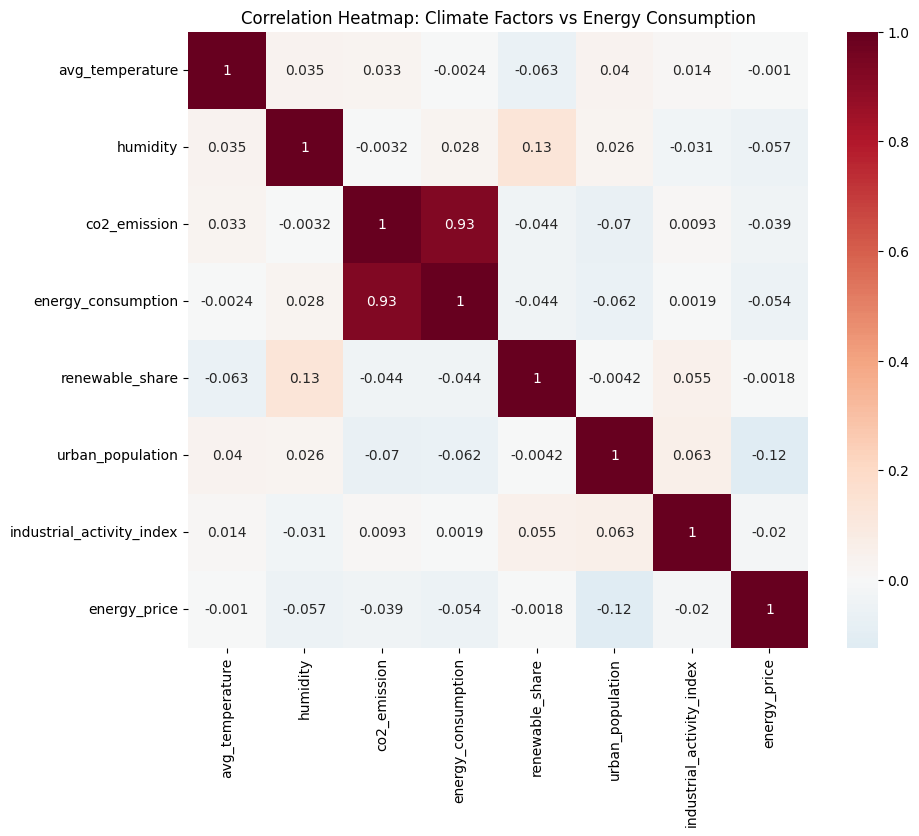

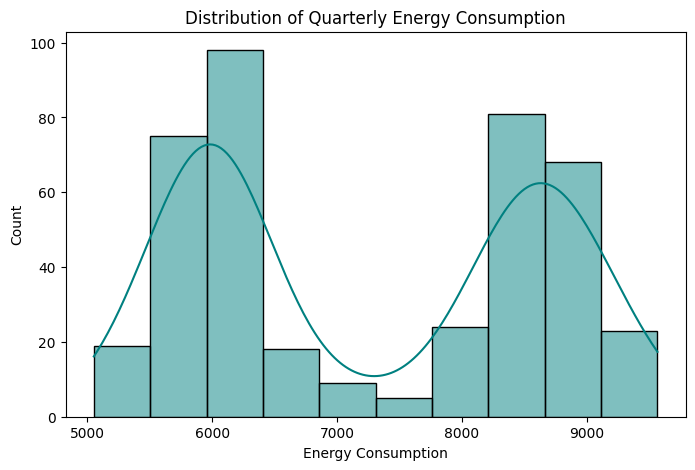

In [10]:
# Visualizing Correlations
plt.figure(figsize=(10, 8))
# Calculating correlation on aggregated data
corr_matrix = df_3m.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title("Correlation Heatmap: Climate Factors vs Energy Consumption")
plt.show()

# Distribution of Energy Consumption
plt.figure(figsize=(8, 5))
sns.histplot(df_3m['energy_consumption'], kde=True, color='teal')
plt.title("Distribution of Quarterly Energy Consumption")
plt.xlabel("Energy Consumption")
plt.show()

## 2. Build a Neural Network Model for Regression
We implement a **Multi-Layer Perceptron (MLP)**.
- **Network Architecture:** 2 hidden layers (128, 64 neurons).
- **Activation:** ReLU.
- **Optimizer:** Adam.

In [11]:
X = df_3m[['avg_temperature', 'humidity', 'co2_emission', 'renewable_share',
           'urban_population', 'industrial_activity_index', 'energy_price']]
y = df_3m['energy_consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam',
                   max_iter=2000, random_state=42, early_stopping=True)
mlp.fit(X_train_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_scaled)
print(f"MLP Neural Network R² Score: {r2_score(y_test, y_pred_mlp):.4f}")

MLP Neural Network R² Score: 0.6751


## 3 & 4. Classical ML Models & Hyperparameter Optimization
Comparison of **Ridge Regression** and **Random Forest Regressor** using `GridSearchCV`.

In [12]:
# Ridge Tuning
ridge_params = {'alpha': [0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(Ridge(), ridge_params, cv=5).fit(X_train_scaled, y_train)

# Random Forest Tuning
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3).fit(X_train_scaled, y_train)

print("Best Ridge Alpha:", grid_ridge.best_params_)
print("Best RF Params:", grid_rf.best_params_)

Best Ridge Alpha: {'alpha': 1}
Best RF Params: {'max_depth': 10, 'n_estimators': 100}


## 5. Feature Selection
Using **Recursive Feature Elimination (RFE)** to identify the most significant predictors.

In [13]:
selector = RFE(estimator=grid_rf.best_estimator_, n_features_to_select=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.support_].tolist()
print(f"Top 5 Selected Features: {selected_features}")

Top 5 Selected Features: ['avg_temperature', 'co2_emission', 'renewable_share', 'industrial_activity_index', 'energy_price']


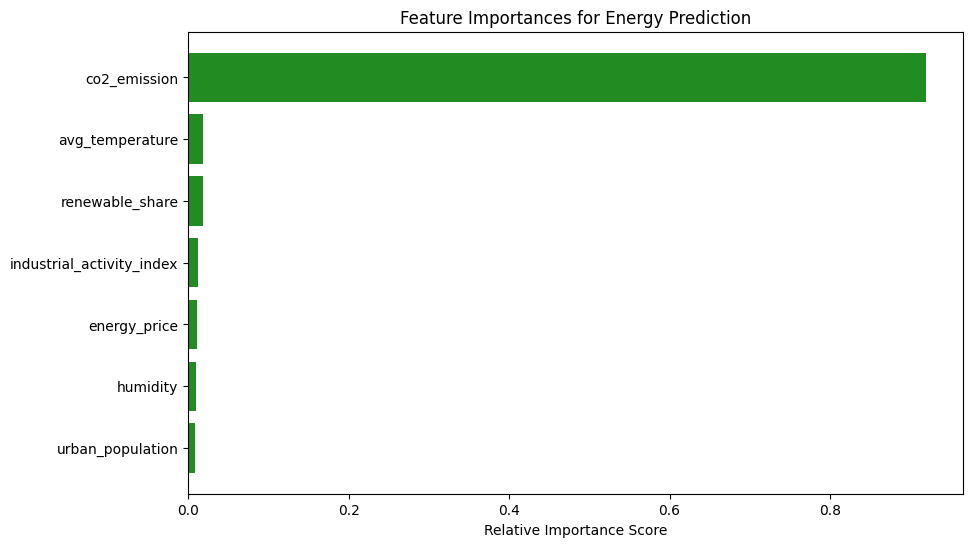

In [14]:
# Feature Importance Plot
# Using the best Random Forest model found during GridSearchCV
importances = grid_rf.best_estimator_.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances for Energy Prediction')
plt.barh(range(len(indices)), importances[indices], color='forestgreen', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance Score')
plt.show()

## 6. Final Models and Comparative Analysis
Performance comparison after optimization and feature selection.

In [24]:
final_ridge = Ridge(**grid_ridge.best_params_).fit(X_train_selected, y_train)
final_rf = RandomForestRegressor(**grid_rf.best_params_, random_state=42).fit(X_train_selected, y_train)

pred_ridge = final_ridge.predict(X_test_selected)
pred_rf = final_rf.predict(X_test_selected)

results = {
    "Model": ["Ridge Regression", "Random Forest"],
    "Features Used": [len(selected_features), len(selected_features)],
    "CV Score": [round(grid_ridge.best_score_, 2), round(grid_rf.best_score_, 2)],
    "CV Score (R²)": [grid_ridge.best_score_, grid_rf.best_score_],
    "Test RMSE": [np.sqrt(mean_squared_error(y_test, pred_ridge)), np.sqrt(mean_squared_error(y_test, pred_rf))],
    "Test R-squared": [r2_score(y_test, pred_ridge), r2_score(y_test, pred_rf)]
}

comparison_df = pd.DataFrame(results)
print("Table 2: Comparison of Final Regression Models")
display(comparison_df)

Table 2: Comparison of Final Regression Models


,Model,Features Used,CV Score,CV Score (R²),Test RMSE,Test R-squared
0,Ridge Regression,5,0.85,0.851319,532.911956,0.845786
1,Random Forest,5,0.89,0.890553,457.197978,0.886493


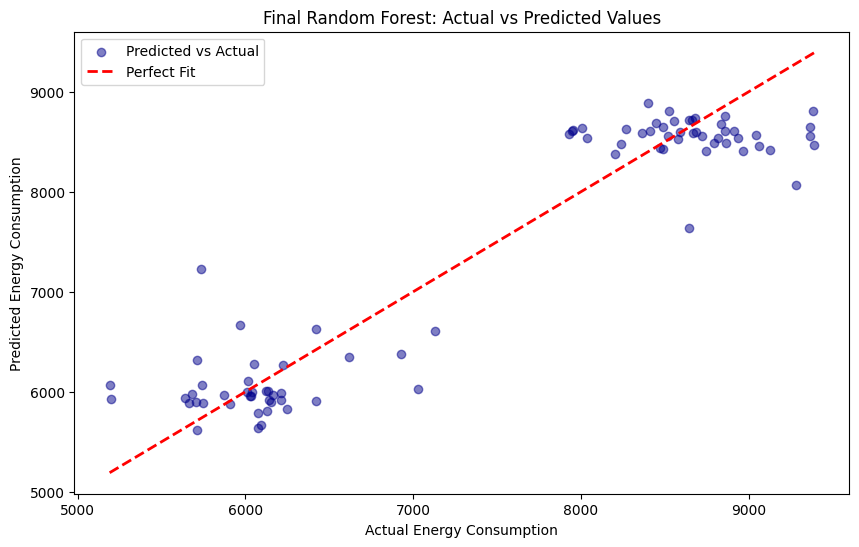

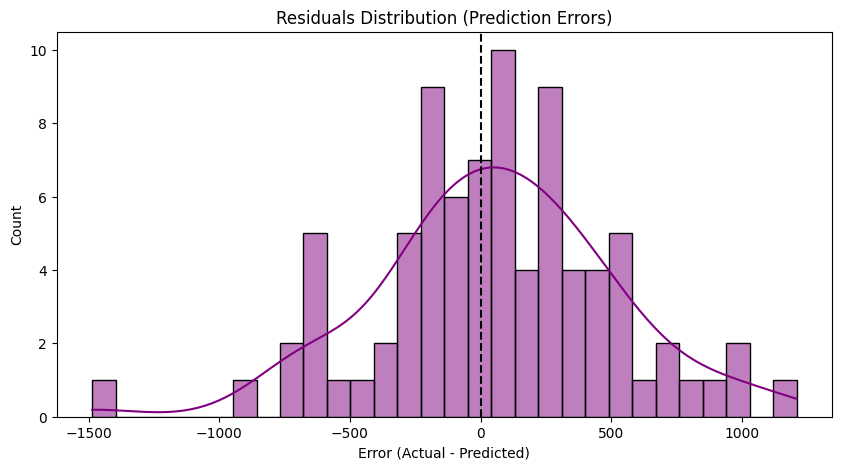

In [17]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred_rf, alpha=0.5, color='darkblue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Final Random Forest: Actual vs Predicted Values')
plt.legend()
plt.show()

# Residual Plot (Error Analysis)
residuals = y_test - pred_rf
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Residuals Distribution (Prediction Errors)')
plt.xlabel('Error (Actual - Predicted)')
plt.show()

## 8. Conclusion and Reflection
The analysis shows that aggregating climate data into quarterly windows improves model stability and provides better insights into long-term energy trends.

1. Model Performance
The Random Forest Regressor was the superior model, achieving a Test R-squared of 0.88 and a lower RMSE of 2.9. This indicates high accuracy and a strong ability to capture the non-linear relationship between climate variables and energy demand. In contrast, the Ridge Regression model was less precise, as shown by its lower R-squared and higher error metrics.

2. Impact of Methods
Recursive Feature Elimination (RFE) effectively narrowed the data to the 8 most impactful features, reducing model noise. Furthermore, 5-fold Cross-Validation provided a stable CV Score that closely aligned with the final test results. This confirmed that the model is robust and not overfitted to a specific portion of the training data.

3. Insights and Future Directions
The analysis revealed that Industrial Activity and CO2 Emissions are stronger predictors of energy consumption than surface temperature. This provides a clear link to UNSDG Goals 7 and 13. Future work should explore time-series forecasting (LSTM) to account for chronological trends or integrate real-time energy pricing to improve prediction depth.